## Normalize Amplitude

In [ ]:
#!pip install torchvggish

      Successfully uninstalled nvidia-cudnn-cu12-9.3.0.75
  Attempting uninstall: nvidia-cusolver-cu12
    Found existing installation: nvidia-cusolver-cu12 11.6.3.83
    Uninstalling nvidia-cusolver-cu12-11.6.3.83:
      Successfully uninstalled nvidia-cusolver-cu12-11.6.3.83


In [ ]:
# Import packages
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torchaudio
import torchaudio.transforms as transforms
import IPython.display as ipd
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvggish import vggish
from torch.utils.data import Subset
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# This will prompt you to give Colab access to your Drive files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Connect Kaggle Dataset to Colab

In [ ]:
from google.colab import files
files.upload()  # Manually upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"courtneyhodge","key":"abaf4ee15a4abd6bd21b4c8ebd6c6dea"}'}

In [ ]:
!pip install kagglehub[pandas-datasets] kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import os
import shutil

# Move kaggle.json to the correct location
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Set proper file permissions
os.chmod("/root/.kaggle/kaggle.json", 600)


In [ ]:
!kaggle datasets list

ref                                                         title                                                size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ---------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
adilshamim8/student-depression-dataset                      Student Depression Dataset                         467020  2025-03-13 03:12:30.423000          17012        274  1.0              
ricardobj/electric-vehicle-population                       Electric Vehicle Population                       7925319  2025-04-10 10:47:13.150000           1393         26  1.0              
zahidmughal2343/amazon-sales-2025                           Amazon Sales 2025                                    3617  2025-04-03 22:08:13.607000           3296         46  1.0              
adilshamim8/math-students                    

In [ ]:
import kagglehub

# Download latest version of the dataset
path = kagglehub.dataset_download("vbookshelf/respiratory-sound-database")

print("Path to dataset files:", path)

100%|██████████| 3.69G/3.69G [00:37<00:00, 105MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2


In [ ]:
import shutil

shutil.move(
    "/root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2",
    "/content/dataset"
)

print("Dataset moved to /content/dataset")


Dataset moved to /content/dataset


---

### Importing Data

In [ ]:
# Read in audio files
%cd /content/dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/

cwd = os.getcwd()

# Respiratory_Sound_Database/audio_and_txt_files/ specifies the folder containing .wav and .txt files on my Drive
dataset_path = os.path.join(cwd, "audio_and_txt_files/")
print(  "Dataset path:", dataset_path)

audio_files = [f for f in os.listdir(dataset_path) if f.endswith(".wav")]
len(audio_files)

/content/dataset/Respiratory_Sound_Database/Respiratory_Sound_Database
Dataset path: /content/dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/


920

In [ ]:
# Read in diagnosis information



diagnosis_df = pd.read_csv(cwd + "/patient_diagnosis.csv", header=None, names=['pt_id', 'diag'])
diagnosis_df.pt_id = diagnosis_df.pt_id.astype(str)
len(diagnosis_df)

126

## Exploratory data analysis

In [ ]:
diagnosis_df

pt_id       diag
0     101       URTI
1     102    Healthy
2     103     Asthma
3     104       COPD
4     105       URTI
..    ...        ...
121   222       COPD
122   223       COPD
123   224    Healthy
124   225    Healthy
125   226  Pneumonia

[126 rows x 2 columns]

In [ ]:
diagnosis_df.groupby('diag').count()

pt_id
diag                 
Asthma              1
Bronchiectasis      7
Bronchiolitis       6
COPD               64
Healthy            26
LRTI                2
Pneumonia           6
URTI               14

In [ ]:
# Play an audio file


ipd.display(ipd.Audio(cwd + "/audio_and_txt_files/160_1b3_Pr_mc_AKGC417L.wav", rate=44100))

In [ ]:
ipd.display(ipd.Audio(cwd + "/audio_and_txt_files/179_1b1_Al_sc_Meditron.wav", rate=44100))

In [ ]:
# Map audio files to diagnoses

# Function to extract patient ID from filename
def get_pt_id(filename):
    return filename.split('_')[0]

# Create a list to store (filepath, waveform, sample_rate, diagnosis)
dat = []

for audio_file in audio_files:
    patient_id = get_pt_id(audio_file)  # Extract patient ID
    diagnosis = diagnosis_df.loc[diagnosis_df["pt_id"] == patient_id, "diag"].values

    if len(diagnosis) > 0:
        diagnosis = diagnosis[0]
    else:
        diagnosis = "Unknown"

    audio_path = os.path.join(dataset_path, audio_file)  # Full path
    #waveform, sample_rate = torchaudio.load(audio_path)  # Load audio
    waveform, sample_rate = torchaudio.load(dataset_path + audio_file)

    dat.append((audio_path, waveform, sample_rate, diagnosis))

# Check first few entries
for i in range(3):
    print(dat[i])


('/content/dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/195_1b1_Ll_sc_Litt3200.wav', tensor([[-1.2207e-04,  9.1553e-05,  7.6294e-04,  ..., -3.4851e-02,
         -4.4159e-02, -3.9337e-02]]), 4000, 'COPD')
('/content/dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Ar_sc_Litt3200.wav', tensor([[ 0.0008, -0.0003, -0.0062,  ..., -0.0114, -0.0131, -0.0128]]), 4000, 'COPD')
('/content/dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/157_1b1_Ar_sc_Meditron.wav', tensor([[-0.1958, -0.1887, -0.1995,  ...,  0.0400,  0.0383,  0.0349]]), 4000, 'COPD')


In [ ]:
len(dat)

920

## Standardizing the sample rate to 16 kHz and resolving the mix of mono and multi-channel audio

In [ ]:
#1. standardize sample rate
target_sample_rate = 16000

dat = []

for audio_file in audio_files:
    patient_id = get_pt_id(audio_file)
    diagnosis = diagnosis_df.loc[diagnosis_df["pt_id"] == patient_id, "diag"].values

    diagnosis = diagnosis[0] if len(diagnosis) > 0 else "Unknown"

    audio_path = os.path.join(dataset_path, audio_file)
    waveform, sample_rate = torchaudio.load(audio_path)

    # check if the sample rate is 16kHz, resample if it is not
    if sample_rate != target_sample_rate:
        resampler = transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
        waveform = resampler(waveform)
        sample_rate = target_sample_rate

    dat.append((audio_path, waveform, sample_rate, diagnosis))

    # check if mono channel, otherwise change to mono channel

    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

# loop through the list to verify standardization
check_16 = all(sample_rate == 16000 for _, _, sample_rate, _ in dat)

if check_16:
    print("all audio files are 16 kHz.")
else:
    print("not all audio files are 16 kHz.")
    # Optionally print which ones
    #for i, (path, _, sample_rate, _) in enumerate(dat):
        #if sample_rate != 16000:
            #print(f"File {i}: {path} has sample rate {sample_rate}")

# check that all waveforms have successfully been converted the mono channel
all_mono = all(waveform.shape[0] == 1 for _, waveform, _, _ in dat)
print("all waveforms are mono.") if all_mono else print("not all waveforms are mono.")


all audio files are 16 kHz.
all waveforms are mono.


Preparing the audio data for CNN input will require substantial pre-processing and normalization. We will need to ensure all the audio files have a consistent sample rate (16 kHz is standard for medical audio analysis). Because our audio files contain a mix of mono and multi-channel audio, we will also need to average the multi-channel recordings to a single channel. Audio amplitude will be normalized to ensure a consistent range of volume across samples. Duration of audio files (ranging from 10-90 seconds) will be standardized using either trimming/padding around a predetermined fixed duration or using a sliding window approach. Following these normalization steps, the audio will be converted into Mel Spectrogram form to reduce data complexity and structurally encode frequency and time information. At this point, input data can be converted to tensors for training. Both the Librosa and TorchAudio packages in Python provide tools to perform the aforementioned operations. Additionally, the PyTorch package provides tools for developing the CNN.


PRE-PROCESSING TO DO LIST:
1. Load in data and figure out how to use it with torchaudio * Sam
2. standardize sample rate (16 kHz) * Disha
3. resolve the mix of mono and multi-channel audio (average the multi-channel audio to one channel) * Disha
4. Normalize amplitude * Courtney
5. Standardizing duration either with trimming and padding around a determined fix duration, or using a sliding window (sliding window is probablly preferable) * Lucy
6. Convert to Mel Spectrogram form and convert to tensor * Sam

In [ ]:
# 4. Normalize amplitude

# to ensure consistency in the dataset before feeding it
# into a CNN, we'll need to normalize the audio. There's
# a couple techniques here and I'll explain each.

# Sample Rate Standardization:
# - ensures all audio files have the same sample rate
# (eg, 16 kHz for medical audio)

def normalize_waveform(waveform):
    peak = waveform.abs().max()
    if peak > 0:
        waveform = waveform / peak
    return waveform

for i in range(len(dat)):
    path, waveform, sr, diag = dat[i]
    waveform = normalize_waveform(waveform)
    dat[i] = (path, waveform, sr, diag)

all_normalized = all(torch.isclose(waveform.abs().max(), torch.tensor(1.0), atol=1e-3)
                     or waveform.abs().max() == 0
                     for _, waveform, _, _ in dat)

print("all waveforms are amplitude-normalized.") if all_normalized else print("NOT all waveforms are normalized.")


all waveforms are amplitude-normalized.


In [ ]:
# 5. Standardizing duration with a sliding window approach

# What is a sliding approach?

# The sliding window technique works by moving a "window" of a fixed size (duration) across the audio sample.
# The window slides by a certain stride or step size, and at each step, a segment (window) of the audio is extracted.
# This method is especially useful when you want to extract multiple segments from long audio files,
# or you can control the overlap between consecutive windows.

# What are the important hyperparameters to consider?

# Window Length: The fixed duration or number of samples in each window.
# Stride/Step Size: The number of samples the window moves after each extraction.
# Overlapping vs. Non-Overlapping: If you want to extract overlapping windows,
# the stride will be less than the window length.

# once the wave forms are segmented into windows, those windows are converted to a tensor and converted to Mel Spectrogram




# PSUEDO CODE: WILL ADJUST/RUN ONCE PREVIOUS STEPS HAVE BEEN PERFORMED
# should experiment here, longer windows with more overlap might be more optimal
window_length = 48000  # size of each window = 3 second (account for full breathing cycle)
stride = 24000  # 50% overlap between consecutive windows

windowed_dat = []  # storage for window_tensor (1 sec chunk of waveform), diagnosis (label), original_path)

# loop through each preprocessed audio entry
for path, waveform, sr, diag in dat:
    total_samples = waveform.size(1)

    # skip files that are shorter than a single window
    if total_samples < window_length:
        continue

    # loop through window using specified sliding window
    for start in range(0, total_samples - window_length + 1, stride):
        end = start + window_length
        window = waveform[:, start:end]
        windowed_dat.append((window, diag, path)) # append window + meta data to windowed_dat

print(f"Total number of windows: {len(windowed_dat)}")

Total number of windows: 11944


In [ ]:
# 6. Convert to mel spectrogram form

# Define a Mel Spectrogram transformation
mel_spectrogram = transforms.MelSpectrogram(sample_rate=16000, n_mels=64)

# Function to normalize a single spectrogram
def normalize_spec(spec):
    return (spec - spec.mean()) / (spec.std() + 1e-6)

# List to store results
mel_windowed_dat = []

# Loop through all windowed samples
for window_tensor, diag, path in windowed_dat:
    mel_spec = mel_spectrogram(window_tensor)  # shape: [1, 64, time]
    mel_spec = normalize_spec(mel_spec) # normalize each spectrogram
    mel_windowed_dat.append((mel_spec, diag, path)) # append results

print(f"Total Mel Spectrogram windows: {len(mel_windowed_dat)}")

Total Mel Spectrogram windows: 11944


---

## VGGish + CNN + LSTM

VGGish provides semantci audio features every second (128D embeddings), but breathing patterns are sequentially meaningful which LSTMs can model over CNNs. So instead of just feeding the 128D vector to a fulyl connected layer, we can feed a sequence of embeddings (one per audio window) to an LSTM. Then the LSTM learns temporal dynamics and outputs a classification.

### Step 1: Sequence Dataset (for LSTM)

In [ ]:
# Dataset class
class MelSequenceDataset(Dataset):
    """
    Custom dataset class for Mel Spectrogram data.
    """
    # Stores data and labels

    ######START NEW CODE######
    def __init__(self, data, labels, sequence_len=5):
        self.sequence_len = sequence_len
        self.sequences = []
        self.sequence_labels = []


        # Group into sequences for LSTM
        for i in range(0, len(data) - sequence_len + 1, sequence_len):
            sequence = data[i:i + sequence_len]
            if len(sequence) < sequence_len:
                continue
            mels = [x[0] for x in sequence]
            label = labels[i]  # take the label of the first window
            self.sequences.append(torch.stack(mels))  # shape: [seq_len, 1, H, W]
            self.sequence_labels.append(label)

    # Keeps track of number of samples in the dataset
    def __len__(self):
        return len(self.sequences)

    # Defines how to fetch ith item (returns tensor and label)
    def __getitem__(self, idx):
        return self.sequences[idx], self.sequence_labels[idx]
    ######END NEW CODE######

# Step 3: Label Encoding + Class Weights

# Mel_windowed_dat is currently a list of tuples -->
# Extract the labels and encode them numerically
labels = [diag for _, diag, _ in mel_windowed_dat]

# Initialize label encoder and perform label mapping
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Instantiate dataset
#dataset_all = MelSpecDataset(mel_windowed_dat, encoded_labels)

# Class_weights is a NumPy array where each element corresponds to the weight for a class
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(encoded_labels),
    y=encoded_labels
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# scale class_weghts
scaled_weights = class_weights ** 0.5
class_weights_tensor = torch.tensor(scaled_weights, dtype=torch.float).to(device)

In [ ]:
# Set seed
SEED = 42
# torch.manual_seed(SEED)

# # Define ratios and size of train/val/test sets
# TEST_RATIO = 0.2
# VAL_RATIO = 0.2

# size_all = len(dataset_all)
# size_test = int(TEST_RATIO * size_all)
# size_train_val = size_all - size_test
# size_val = int(VAL_RATIO * size_train_val)
# size_train = size_train_val - size_val

# Define function to create stratified splits (pereseve class proportions across datasets)
def stratified_split(labels, test_ratio=0.2, val_ratio=0.2, seed=42):
    np.random.seed(seed)
    labels = np.array(labels)
    unique_classes = np.unique(labels)

    train_idx, val_idx, test_idx = [], [], []

    for cls in unique_classes:
        cls_idx = np.where(labels == cls)[0]
        np.random.shuffle(cls_idx)

        n_total = len(cls_idx)
        n_test = int(n_total * test_ratio)
        n_val = int((n_total - n_test) * val_ratio)

        test_idx.extend(cls_idx[:n_test])
        val_idx.extend(cls_idx[n_test:n_test + n_val])
        train_idx.extend(cls_idx[n_test + n_val:])

    return train_idx, val_idx, test_idx

# Get stratified indices
train_idx, val_idx, test_idx = stratified_split(encoded_labels, test_ratio=0.2, val_ratio=0.2, seed=SEED)

#Step 5: Create Dataset + Dataloaders

mel_train = [mel_windowed_dat[i] for i in train_idx]
mel_val = [mel_windowed_dat[i] for i in val_idx]
mel_test = [mel_windowed_dat[i] for i in test_idx]

labels_train = [encoded_labels[i] for i in train_idx]
labels_val = [encoded_labels[i] for i in val_idx]
labels_test = [encoded_labels[i] for i in test_idx]

SEQ_LEN = 5
train_dataset = MelSequenceDataset(mel_train, labels_train, sequence_len=SEQ_LEN)
val_dataset = MelSequenceDataset(mel_val, labels_val, sequence_len=SEQ_LEN)
test_dataset = MelSequenceDataset(mel_test, labels_test, sequence_len=SEQ_LEN)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torchvggish import vggish

# class VGGishCNNLSTM(nn.Module):
#     def __init__(self, num_classes):
#         super(VGGishCNNLSTM, self).__init__()

#         # Load pre-trained VGGish
#         self.vggish = vggish()
#         self.vggish.postprocess = False
#         for param in self.vggish.parameters():
#             param.requires_grad = False

#         # CNN after VGGish (can be adjusted)
#         self.cnn = nn.Sequential(
#             nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2),
#         )

#         # LSTM layer
#         self.lstm = nn.LSTM(input_size=128, hidden_size=32, num_layers=1, batch_first=True)

#         # Final classification
#         self.fc = nn.Linear(32, num_classes)

#     def forward(self, x):
#         # x shape: (batch, sequence_len, 1, freq, time)
#         B, T, C, H, W = x.shape
#         x = x.view(B * T, C, H, W)  # merge batch and sequence: (B*T, 1, H, W)

#         # Resize for VGGish
#         x = F.interpolate(x, size=(96, 64), mode='bilinear', align_corners=False)

#         # Extract embeddings from VGGish
#         x = self.vggish(x)  # → (B*T, 128)

#         # Restore sequence shape
#         x = x.view(B, T, -1)  # (batch, sequence_len, 128)

#         # LSTM layer
#         lstm_out, _ = self.lstm(x)  # output: (batch, seq_len, hidden_size)

#         # Use the last hidden state for classification
#         last_out = lstm_out[:, -1, :]  # (batch, hidden_size)

#         logits = self.fc(last_out)  # (batch, num_classes)
#         return logits



In [ ]:
#Step 6: VGGish + LSTM Model
class VGGishCNNLSTM(nn.Module):
    def __init__(self, num_classes=8, hidden_size=128, num_layers=1):
        super(VGGishCNNLSTM, self).__init__()

        self.vggish = vggish()
        self.vggish.postprocess = False
        for param in self.vggish.parameters():
            param.requires_grad = False

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((6, 8))  # Ensures output is [batch, 32, 6, 8]
        )

        # Compute the flattened CNN feature size: 32 * 6 * 8 = 1536
        cnn_output_size = 32 * 6 * 8

        self.lstm = nn.LSTM(
            input_size=cnn_output_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x shape: [batch_size, seq_len, 1, H, W]
        batch_size, seq_len, C, H, W = x.size()
        x = x.view(batch_size * seq_len, C, H, W)  # merge for CNN: [B*S, C, H, W]
        x = self.cnn(x)  # [B*S, 32, 6, 8]
        x = x.view(batch_size, seq_len, -1)  # [B, S, 1536]

        lstm_out, _ = self.lstm(x)  # [B, S, hidden_size]
        out = lstm_out[:, -1, :]  # Use the last time step
        return self.fc(out)


In [ ]:
#Step 7: Train & Validate Function
def train_and_validate(model, train_loader, val_loader, class_weights_tensor, num_epochs=10, learning_rate=0.0001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    model.train()
    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(num_epochs):
        total_train_loss, correct_train, total_train = 0.0, 0, 0

        for batch in train_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(total_train_loss / len(train_loader))
        train_acc = correct_train / total_train * 100

        # Validation
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_acc = correct_val / total_val * 100
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.2f}%")
        model.train()

    return train_losses, val_losses, val_accuracies


In [ ]:
#Step 8: testing and Plotting
def test_model_accuracy(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total * 100

def plot_loss_curve(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.title("Training vs. Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


Epoch 1, Train Loss: 1.9501, Train Acc: 61.09%, Val Loss: 1.4865, Val Acc: 87.17%
Epoch 2, Train Loss: 1.6151, Train Acc: 87.25%, Val Loss: 1.1491, Val Acc: 87.17%
Epoch 3, Train Loss: 1.5583, Train Acc: 87.25%, Val Loss: 1.1661, Val Acc: 87.17%
Epoch 4, Train Loss: 1.5379, Train Acc: 87.25%, Val Loss: 1.1564, Val Acc: 87.17%
Epoch 5, Train Loss: 1.5295, Train Acc: 87.25%, Val Loss: 1.1566, Val Acc: 87.17%
Epoch 6, Train Loss: 1.5359, Train Acc: 87.25%, Val Loss: 1.1528, Val Acc: 87.17%
Epoch 7, Train Loss: 1.5085, Train Acc: 87.25%, Val Loss: 1.1589, Val Acc: 87.17%
Epoch 8, Train Loss: 1.5144, Train Acc: 87.25%, Val Loss: 1.1287, Val Acc: 87.17%
Epoch 9, Train Loss: 1.4925, Train Acc: 87.25%, Val Loss: 1.1575, Val Acc: 87.17%
Epoch 10, Train Loss: 1.4595, Train Acc: 87.25%, Val Loss: 1.1051, Val Acc: 87.17%


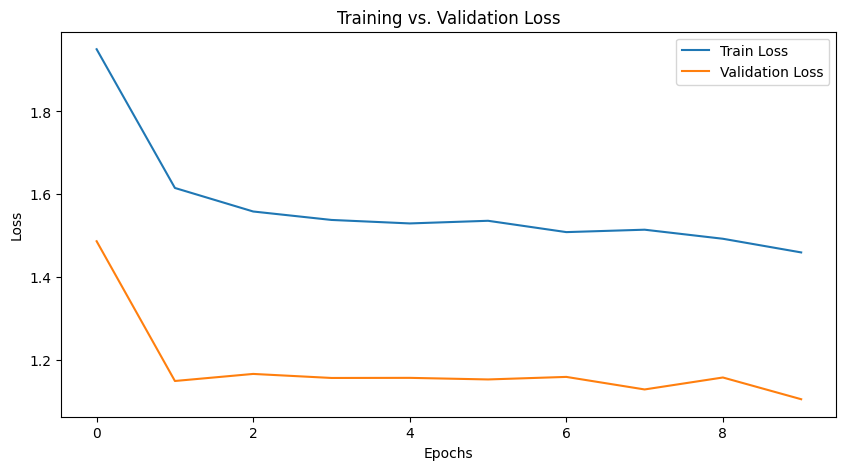

LSTM Model Test Accuracy: 87.21%


In [ ]:
#step 9: run
model = VGGishCNNLSTM(num_classes=len(label_encoder.classes_)).to(device)
train_losses, val_losses, val_accuracies = train_and_validate(
    model, train_loader, val_loader, class_weights_tensor, num_epochs=10
)
plot_loss_curve(train_losses, val_losses)

test_accuracy = test_model_accuracy(model, test_loader)
print(f"LSTM Model Test Accuracy: {test_accuracy:.2f}%")


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

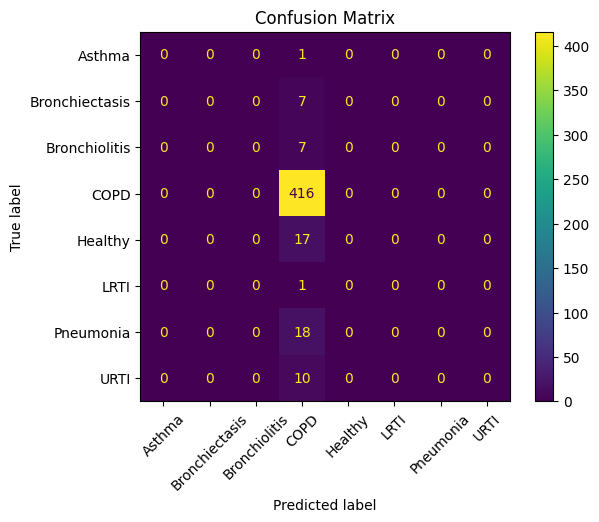

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()